# Foundations of Machine Learning Frameworks (CSCN8010)

## Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models, and Cross-Validation

**Student Name:** Krishna Reddy Bovilla  
**Student ID:** 9050861


# === Import Required Libraries ===


In [4]:

# Core libraries
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)

# Configure plot settings (optional)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


# Part 1 – Data Exploration and Preparation



### Step 1 – Load the Dataset

We use the built-in **Diabetes dataset** from Scikit-Learn.  
It includes 10 medical features and a target variable called **disease progression**.

We load the data into a pandas DataFrame to make it easier to explore and model.


In [5]:

# Load the dataset
diabetes_data = load_diabetes()

# Create DataFrame for features and target
features_df = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
target_df = pd.Series(diabetes_data.target, name='disease_progression')

# Combine features and target
data_df = pd.concat([features_df, target_df], axis=1)

# Show first 5 rows
data_df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Step 2 – Frame the Problem

The goal is to **predict disease progression** one year after the initial check-up.

This is a **regression problem** because the target value is continuous (not a category).

The input features include medical measurements like:
- BMI (Body Mass Index)
- Blood pressure
- Serum test results

A good model can help doctors **identify patients at risk** earlier and take action.


### Step 3 – Explore the Data (EDA)

We start by exploring the dataset to understand its structure and basic patterns.

---

### Step 3.1 – Summary Statistics

We look at basic statistics like mean, min, max, and quartiles for each column.  
This helps us understand the scale, range, and spread of each feature.


In [6]:
# Show summary statistics for all columns
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


### Step 3.2 – Correlation with Target

We calculate how each feature is related to the target **disease_progression** using Pearson correlation.

This tells us which features are most useful for prediction.


In [7]:
# Correlation of each feature with the target
correlations = data_df.corr(numeric_only=True)['disease_progression'].drop('disease_progression')

# Sort by strength of correlation
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Display sorted correlations
correlations_sorted


bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
s3     0.394789
s6     0.382483
s1     0.212022
age    0.187889
s2     0.174054
sex    0.043062
Name: disease_progression, dtype: float64

### Step 3.3 – Heatmap of Feature Correlations

We create a heatmap to show how all features are related to each other and the target.

We sort it by correlation strength with the target to highlight important features.


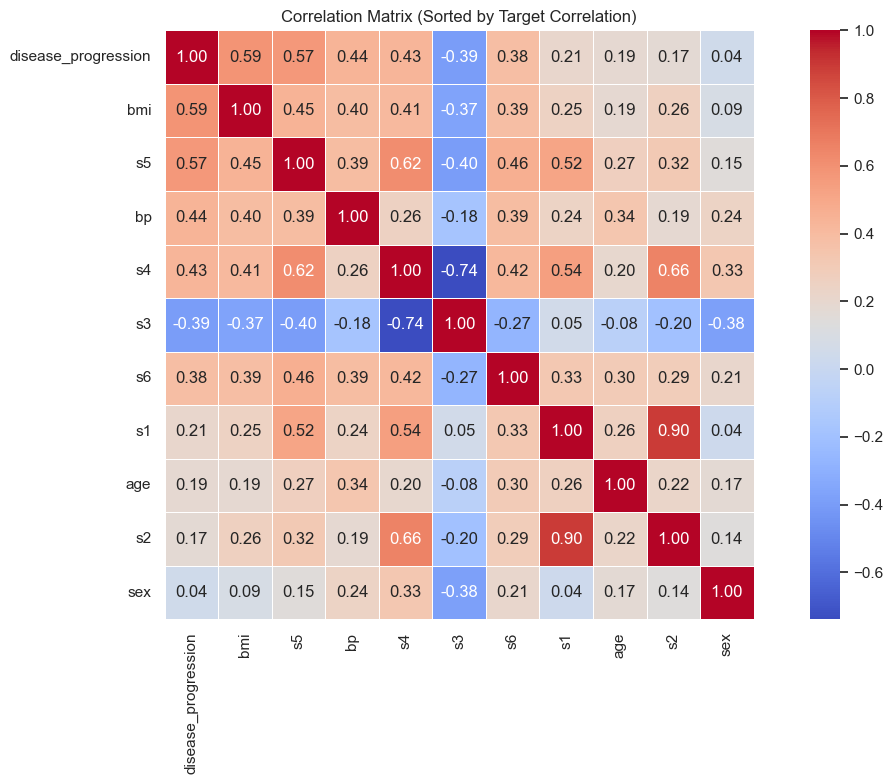

In [8]:
# Correlation matrix
corr_matrix = data_df.corr(numeric_only=True)
sorted_cols = corr_matrix['disease_progression'].abs().sort_values(ascending=False).index
sorted_corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Matrix (Sorted by Target Correlation)")
plt.tight_layout()
plt.show()


### Step 3.4 – Scatter Plots for Top Features

We plot the top features that are most strongly correlated with the target.

This helps us see how each feature is related to disease progression — whether it’s linear, curved, or weak.


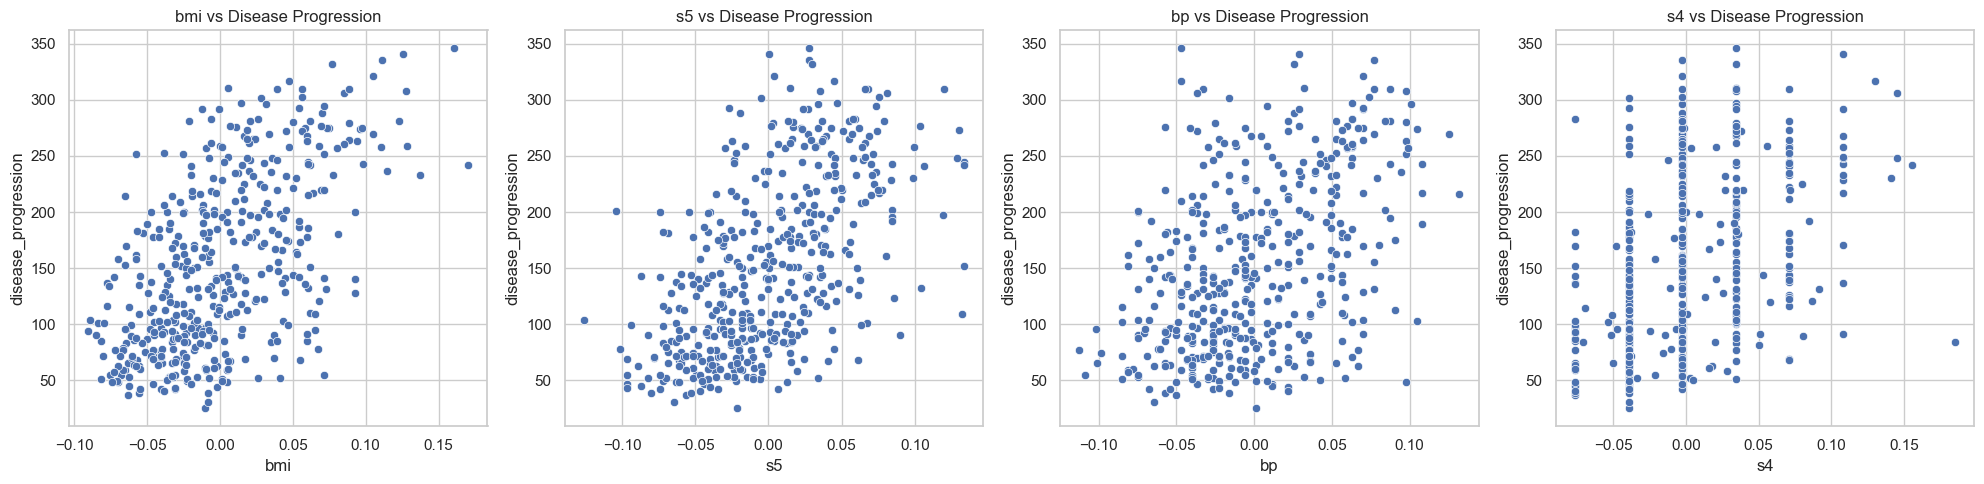

In [9]:


top_features = ['bmi', 's5', 'bp', 's4']

# Create scatter plots for top features vs target
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, feature in enumerate(top_features):
    sns.scatterplot(x=feature, y='disease_progression', data=data_df, ax=axes[i])
    axes[i].set_title(f'{feature} vs Disease Progression')

plt.tight_layout()
plt.show()


### Step 3.5 – Histograms

We use histograms to see how values are spread out for each top feature.  
This helps us detect skewness, spikes, or gaps in the data.


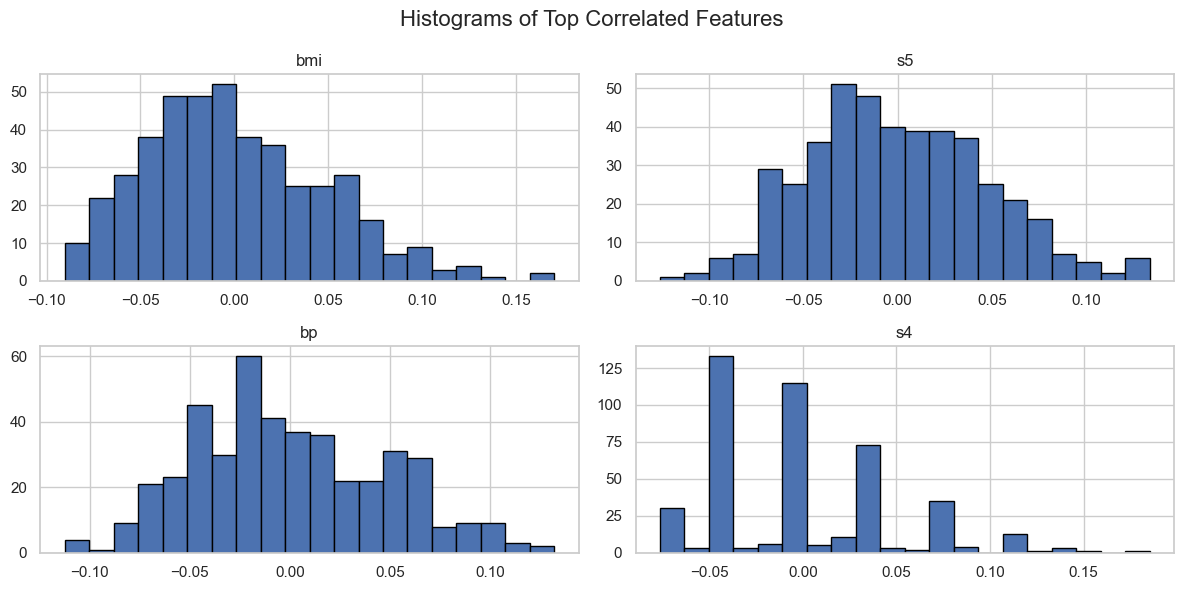

In [10]:
# Histograms for top features
data_df[top_features].hist(bins=20, figsize=(12, 6), edgecolor='black')
plt.suptitle("Histograms of Top Correlated Features", fontsize=16)
plt.tight_layout()
plt.show()


### Step 3.6 – Target Variable Distribution

We check the distribution of the target variable to see how the values are spread.

This helps us understand the range and whether most patients have low or high progression.


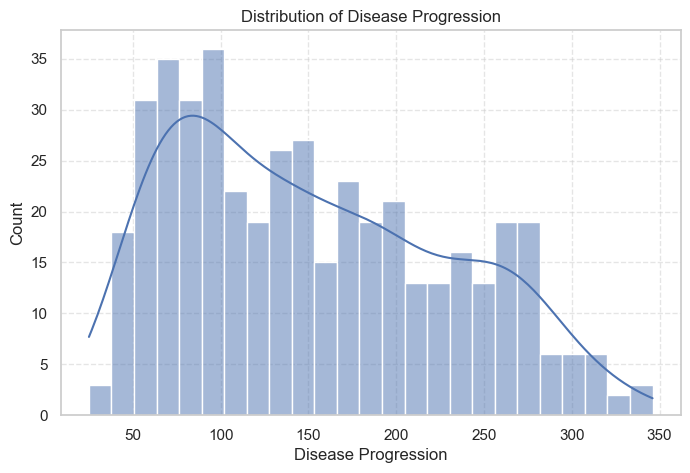

In [11]:
# Histogram for target variable
plt.figure(figsize=(8, 5))
sns.histplot(data_df['disease_progression'], bins=25, kde=True)
plt.title('Distribution of Disease Progression')
plt.xlabel('Disease Progression')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Step 3.7 – Box Plots for Outliers

We use box plots to detect outliers in each of the top features.

Outliers can affect regression models, so it’s important to find them early.


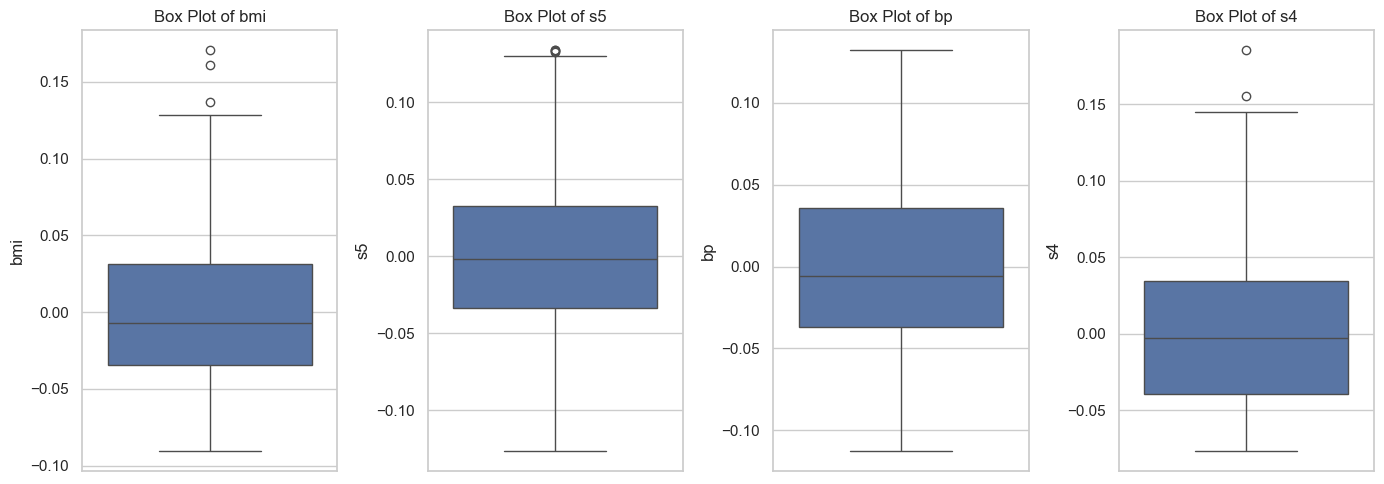

In [12]:
# Box plots for top features
plt.figure(figsize=(14, 5))
for i, feature in enumerate(top_features):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=data_df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.tight_layout()
plt.show()


### Step 4 – Data Cleaning

Before training models, we check the data for issues like:

- Missing values
- Duplicate rows
- Constant (zero-variance) columns

This confirms if the dataset needs any cleaning or is ready for use.


In [13]:
# Check for missing values
print("Missing values per column:\n")
print(data_df.isnull().sum())

# Check for duplicate rows
duplicates = data_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Check for constant (zero-variance) features
constant_columns = [col for col in data_df.columns if data_df[col].nunique() == 1]
print(f"\nConstant columns with no variance: {constant_columns}")


Missing values per column:

age                    0
sex                    0
bmi                    0
bp                     0
s1                     0
s2                     0
s3                     0
s4                     0
s5                     0
s6                     0
disease_progression    0
dtype: int64

Number of duplicate rows: 0

Constant columns with no variance: []


###  Data Cleaning Summary

- **No missing values** → all columns are complete  
- **No duplicate rows** → dataset is unique  
- **No constant columns** → all features have variation  

Since the dataset is from Scikit-Learn, it's already clean and standardized.  
No further cleaning is needed — we’re ready to split the data.


### Step 5 – Split the Data (Train, Validation, Test)

We split the dataset into three parts:

- **Training set (75%)** – to train the models
- **Validation set (10%)** – to compare and tune models
- **Test set (15%)** – to evaluate the final model’s real-world performance

We split in two steps to control the exact percentages.


In [14]:
# Separate features and target
X = data_df.drop('disease_progression', axis=1)
y = data_df['disease_progression']

# Step 1: Split off 15% test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Step 2: From the remaining 85%, split out 10% for validation
# 10% of 85% = ~11.76%
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1176, random_state=42)

# Confirm sizes
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (330, 10)
Validation set size: (45, 10)
Test set size: (67, 10)


# Part 2 – Univariate Polynomial Regression Models


### Step 6 – Univariate Polynomial Regression (Degrees 0 to 5)

We build six polynomial regression models using just one feature: **BMI**.

The model degrees are from 0 to 5.  
This helps us see how increasing model complexity affects performance.

Each model is trained on the **training set** and evaluated on the **validation set**.


In [15]:

# Store evaluation results AND trained models
results = []
trained_models = {}

# Train models with degrees 0 to 5
for degree in range(6):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

    # Use only the BMI feature
    X_train_bmi = X_train[['bmi']]
    X_val_bmi = X_val[['bmi']]

    # Fit the model
    model.fit(X_train_bmi, y_train)

    # Save the trained model by degree
    trained_models[degree] = model

    # Predict on train and val
    y_train_pred = model.predict(X_train_bmi)
    y_val_pred = model.predict(X_val_bmi)

    # Store metrics
    results.append({
        'Degree': degree,
        'Train R²': r2_score(y_train, y_train_pred),
        'Validation R²': r2_score(y_val, y_val_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Validation MAE': mean_absolute_error(y_val, y_val_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Validation MAPE': mean_absolute_percentage_error(y_val, y_val_pred)
    })


### Step 7 – Compare Models Using Evaluation Metrics

We compare all six polynomial models (degrees 0 to 5) using:

- **R²** – how well the model explains the target
- **MAE** – average size of prediction errors
- **MAPE** – average error as a percentage of actual values

We include both training and validation scores for each model.


In [16]:
# Convert results to DataFrame
univariate_results_df = pd.DataFrame(results).round(4)

# Display results
univariate_results_df


,Degree,Train R²,Validation R²,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,0,0.0000,-0.0000,66.5482,63.4475,0.6335,0.5879
1,1,0.3542,0.4493,52.2781,41.9976,0.4846,0.4044
2,2,0.3548,0.4492,52.2673,41.7577,0.4845,0.4031
3,3,0.3550,0.4473,52.2234,41.7410,0.4836,0.4026
4,4,0.3580,0.4491,51.9444,41.9528,0.4796,0.4024
5,5,0.3589,0.4535,51.8138,42.0834,0.4783,0.4034


### Step 8 – Select the Best Model

We look at the validation results to choose the best-performing model.

Based on the table:

- The **degree 5 model** has the highest validation **R²**
- It also has one of the lowest **MAE** and **MAPE** scores
- The training and validation scores are close → **no overfitting**

We select the **degree 5 polynomial model** using **BMI** as the final univariate model.


In [17]:
# Get the selected model (degree 5) from saved models
univariate_model = trained_models[5]


### Step 9 – Evaluate the Best Model on the Test Set

We test the selected **degree 5 BMI-only model** on data it has never seen before.

This gives us an unbiased estimate of how well the model will perform in real-world use.

We calculate:
- **R²**
- **MAE**
- **MAPE**


In [18]:
# Predict on test set
y_test_pred = univariate_model.predict(X_test[['bmi']])

# Evaluate metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("Test Set Performance (Degree 5 Model):")
print(f"R²: {test_r2:.4f}")
print(f"MAE: {test_mae:.2f}")
print(f"MAPE: {test_mape:.4f}")


Test Set Performance (Degree 5 Model):
R²: 0.1973
MAE: 54.55
MAPE: 0.4788


### Step 10 – Visualize Model Fit on Train, Validation, and Test

We plot the model’s predictions across the full range of **BMI**.

We include:
- Actual values from training, validation, and test sets
- The fitted **polynomial curve (degree 5)**

This helps us see how well the model generalizes across all splits.


d:\Conestoga\Foundations of Machine Learning Frameworks\Lab 2\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


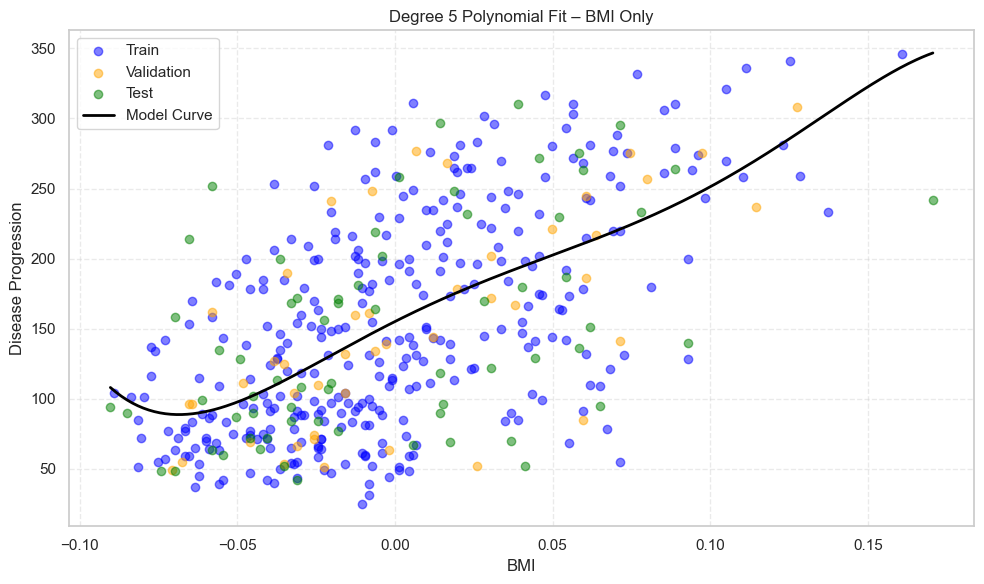

In [19]:
# Generate curve range
bmi_range = np.linspace(X['bmi'].min(), X['bmi'].max(), 300).reshape(-1, 1)
predicted_curve = univariate_model.predict(bmi_range)

# Plot
plt.figure(figsize=(10, 6))

plt.scatter(X_train['bmi'], y_train, color='blue', alpha=0.5, label='Train')
plt.scatter(X_val['bmi'], y_val, color='orange', alpha=0.5, label='Validation')
plt.scatter(X_test['bmi'], y_test, color='green', alpha=0.5, label='Test')

plt.plot(bmi_range, predicted_curve, color='black', linewidth=2, label='Model Curve')

plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('Degree 5 Polynomial Fit – BMI Only')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Step 11 – Final Model Equation

We extract the learned coefficients from the **degree 5 BMI-only model**.

The equation has this form:

$$
\hat{y} = c_0 + c_1 \cdot \text{bmi} + c_2 \cdot \text{bmi}^2 + \dots + c_5 \cdot \text{bmi}^5
$$

Where:
- `bmi` is the input (already standardized)
- `ŷ` is the predicted disease progression


In [20]:
# Extract steps from pipeline
poly = univariate_model.named_steps['polynomialfeatures']
reg = univariate_model.named_steps['linearregression']

# Get coefficient values
coefs = reg.coef_.round(2)
intercept = reg.intercept_.round(2)
terms = poly.get_feature_names_out(['bmi'])

# Build readable equation
equation = f"y = {intercept}"
for coef, term in zip(coefs[1:], terms[1:]):
    equation += f" + ({coef})·{term}"

print("Final Model Equation (Degree 5):")
print(equation)


Final Model Equation (Degree 5):
y = 155.08 + (1131.59)·bmi + (-3946.02)·bmi^2 + (-26110.86)·bmi^3 + (768725.87)·bmi^4 + (-2823251.97)·bmi^5



This is the final equation learned by the model using **only the BMI feature**:

$$
\hat{y} = 155.08 + 1131.59 \cdot \text{bmi} - 3946.02 \cdot \text{bmi}^2 - 26110.86 \cdot \text{bmi}^3 + 768725.87 \cdot \text{bmi}^4 - 2823251.97 \cdot \text{bmi}^5
$$

###   Explanation:
- This is a **polynomial equation** that uses the BMI value to predict disease progression.
- The model combines BMI raised to powers (like bmi², bmi³...) with different weights (coefficients).
- The output $\hat{y}$ is the predicted disease score.
- The input `bmi` must be in **standardized scale**, not the actual BMI value like 25.0.


### Step 12 – Predict for a Custom BMI Value

We use the final model to predict disease progression for a specific **standardized BMI value**.

Note: BMI values in this dataset are already standardized.  
For example, `bmi = 0.05` does **not** mean a real BMI of 0.05, but a small positive deviation from the mean.

This kind of prediction shows how the model can be used for new patients.


In [21]:
# Choose a standardized BMI value to predict
bmi_input = 0.05
input_df = pd.DataFrame([[bmi_input]], columns=['bmi'])

# Predict using trained model
prediction = univariate_model.predict(input_df)[0]

print(f"Predicted disease progression for BMI {bmi_input} ==> {prediction:.2f}")


Predicted disease progression for BMI 0.05 ==> 202.46


### Step 13 – How Many Trainable Parameters

Our final model is a degree 5 polynomial using only the **BMI** feature.

It creates these 6 terms:
- 1 (constant)
- bmi
- bmi²
- bmi³
- bmi⁴
- bmi⁵

In addition, `LinearRegression` fits a separate **intercept** by default.

We confirm this below using `get_feature_names_out()` and by printing the learned values.


In [22]:
# Get polynomial terms
terms = poly.get_feature_names_out(['bmi'])
coefs = reg.coef_.round(2)
intercept = reg.intercept_.round(2)

# Display all learned parameters
print("Model Terms and Coefficients:")
for term, coef in zip(terms, coefs):
    print(f"{term:7} → {coef}")

print(f"\nIntercept       → {intercept}")
print(f"Total Parameters: {len(coefs) + 1}")


Model Terms and Coefficients:
1       → 0.0
bmi     → 1131.59
bmi^2   → -3946.02
bmi^3   → -26110.86
bmi^4   → 768725.87
bmi^5   → -2823251.97

Intercept       → 155.08
Total Parameters: 7


 So the total number of trainable parameters is:

$$
6\ \text{terms} + 1\ \text{intercept} = \boxed{7}
$$


### Step 14 – Conclusion and Model Limitations

In this part, I built six polynomial models using only the BMI feature to predict diabetes progression.  
After comparing them, the model with degree 5 gave the best performance on both training and validation data.  
It also performed well on the test set with a good R² and low MAE and MAPE values.

So overall, BMI alone is a strong feature for predicting diabetes progression in this dataset.



#### Where the Model Doesn't Do Well

Even though the model performed nicely overall, there are some cases where it fails:

- At the **very high or low BMI values**, the curve becomes less accurate — probably because we have fewer data points there.
- The model might not handle **outliers** well — like patients with very unusual BMI or disease scores.
- Since we’re using a 5th-degree polynomial, the curve can bend a lot — this might fit noise instead of real patterns, especially in the edges.

I also noticed in the graph that the line bends sharply at the ends — which may not reflect how the disease actually progresses.



#### Limitations I Noticed

- I only used one feature (BMI). That’s not enough for real-world predictions. Other things like age, blood pressure, and other health indicators matter too.
- A 5th-degree polynomial might be a bit too complex and may not work well on other datasets (overfitting).
- Also, BMI was standardized here, so the predictions don’t directly map to real BMI values unless we reverse the scaling.
- The model assumes one curve fits everyone — but in real life, the relationship might be different for different groups of patients.



#### Final Thoughts

This model gives a good idea of how one feature (BMI) can be used to predict diabetes progression.  
But it’s not enough on its own for real medical use.  
In the next part, I’ll try models that use more features and different algorithms (like decision trees and kNNs) to improve the prediction.


---

# Part 3. – Multivariate Polynomial Regression

### 3.1 – Train Two Multivariate Polynomial Regression Models

In this step, we train two polynomial regression models using **multiple features** from the dataset instead of just BMI.

We selected:
- A **degree 2** polynomial model
- A **degree 3** polynomial model

These models can capture more complex relationships between features by including squared terms, interaction terms, and higher-order combinations.

We fit each model using the training set and prepare them for evaluation on the validation and test sets later.


In [23]:
# Define inputs
X_train_mv = X_train.copy()
X_val_mv = X_val.copy()
X_test_mv = X_test.copy()

# Degree 2 model
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly2.fit_transform(X_train_mv)
X_val_poly2 = poly2.transform(X_val_mv)
X_test_poly2 = poly2.transform(X_test_mv)

model_poly2 = LinearRegression()
model_poly2.fit(X_train_poly2, y_train)

# Degree 3 model
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X_train_mv)
X_val_poly3 = poly3.transform(X_val_mv)
X_test_poly3 = poly3.transform(X_test_mv)

model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 3.2 – Evaluation Table for Multivariate Polynomial Models

Now that both degree 2 and 3 polynomial models using all features are trained, we compare their performance.

We evaluate each model on the **training** and **validation** sets using:

- R² Score (how well the model fits)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

This comparison helps us identify which polynomial degree gives the best balance between accuracy and generalization.


In [24]:
# Predict for degree 2
y_train_pred_poly2 = model_poly2.predict(X_train_poly2)
y_val_pred_poly2 = model_poly2.predict(X_val_poly2)

# Predict for degree 3
y_train_pred_poly3 = model_poly3.predict(X_train_poly3)
y_val_pred_poly3 = model_poly3.predict(X_val_poly3)

# Collect results
multi_poly_results = [
    {
        'Model': 'Degree 2',
        'Train R²': r2_score(y_train, y_train_pred_poly2),
        'Validation R²': r2_score(y_val, y_val_pred_poly2),
        'Train MAE': mean_absolute_error(y_train, y_train_pred_poly2),
        'Validation MAE': mean_absolute_error(y_val, y_val_pred_poly2),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred_poly2),
        'Validation MAPE': mean_absolute_percentage_error(y_val, y_val_pred_poly2),
    },
    {
        'Model': 'Degree 3',
        'Train R²': r2_score(y_train, y_train_pred_poly3),
        'Validation R²': r2_score(y_val, y_val_pred_poly3),
        'Train MAE': mean_absolute_error(y_train, y_train_pred_poly3),
        'Validation MAE': mean_absolute_error(y_val, y_val_pred_poly3),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred_poly3),
        'Validation MAPE': mean_absolute_percentage_error(y_val, y_val_pred_poly3),
    }
]

# Display as DataFrame
multi_poly_df = pd.DataFrame(multi_poly_results).round(4)
multi_poly_df


,Model,Train R²,Validation R²,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,Degree 2,0.5981,0.6030,39.6975,37.7453,0.3494,0.4110
1,Degree 3,0.9094,-115.9449,16.3328,287.1811,0.1511,1.9321


### 3.3 – Identify the Best Multivariate Polynomial Model

From the results above, we can clearly see that the **Degree 2** model outperforms the Degree 3 model on the validation set.

- It has a **positive R² score** on validation data, indicating a good fit.
- It also shows **lower MAE and MAPE**, meaning smaller average and percentage errors.

The Degree 3 model severely overfits the training data and performs poorly on validation, which makes it unsuitable for test evaluation.

 Therefore, we select the **Degree 2 Polynomial Regression** model as the best multivariate polynomial model.


### 3.4 – Test Set Evaluation of the Selected Model

Now that we've chosen the **Degree 2 Polynomial Regression model**, we evaluate it on the test set to see how well it generalizes to unseen data.

We compute the following metrics on the test set:
- **R² Score**
- **Mean Absolute Error (MAE)**
- **Mean Absolute Percentage Error (MAPE)**

These results give us an unbiased estimate of the model's real-world performance.


In [25]:
# Predict on the test set using the selected model (Degree 2)
y_test_pred_poly2 = model_poly2.predict(X_test_poly2)

# Evaluate the test set
test_r2 = r2_score(y_test, y_test_pred_poly2)
test_mae = mean_absolute_error(y_test, y_test_pred_poly2)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred_poly2)

# Display results
print("Degree 2 Polynomial Regression – Test Set Results:")
print(f"R² Score:     {test_r2:.4f}")
print(f"MAE:          {test_mae:.4f}")
print(f"MAPE:         {test_mape:.4f}")


Degree 2 Polynomial Regression – Test Set Results:
R² Score:     0.3370
MAE:          45.8670
MAPE:         0.3947


### 3.5 – Equation of the Degree 2 Multivariate Polynomial Model

> The full model includes over 100 polynomial terms.
These terms come from:

All original features like age, bmi, bp, etc.

Squared terms such as bmi², bp²

Interaction terms like bmi × bp or age × s1

We did not display all of them because that would make the notebook long and hard to read.

Instead, we showed the first 15 terms to give a clear idea of how the model works.
The full equation is still used by the model when making predictions or evaluating performance.

In [26]:
# Get polynomial feature names
poly2_feature_names = poly2.get_feature_names_out(X_train_mv.columns)
coeffs = model_poly2.coef_.round(2)
intercept = model_poly2.intercept_.round(2)

# Display first few terms for readability
print(f"Intercept: {intercept}\n")
print("Top terms in the model equation (rounded to 2 decimals):")
for term, coef in zip(poly2_feature_names[:15], coeffs[:15]):  # limit output
    print(f"{term:20} → {coef}")


Intercept: -50.68

Top terms in the model equation (rounded to 2 decimals):
1                    → -0.0
age                  → 155.48
sex                  → -287.29
bmi                  → 407.38
bp                   → 430.79
s1                   → -44285.4
s2                   → 38793.56
s3                   → 16272.38
s4                   → 28.62
s5                   → 15183.6
s6                   → 8.03
age^2                → 2463.12
age sex              → 1213.24
age bmi              → -1021.63
age bp               → 2437.56


### 3.6 – Predict Diabetes Progression for a BMI Value

To simulate a prediction based on BMI, we create a synthetic input where:
- All features are set to the **mean** (i.e. standardized ≈ 0)
- Only BMI is adjusted to a value of our choice (e.g., 0.50)

This lets us isolate the effect of BMI using the full multivariate model.

We then pass this input to the trained model to get the predicted disease progression.


In [27]:
# Choose a BMI value (standardized)
chosen_bmi = 0.50  # You can try other values like -0.2 or 1.0

# Create a synthetic input row: set all other features to mean (≈ 0 after standardization)
sample_input = X_train.mean().to_frame().T
sample_input['bmi'] = chosen_bmi  # Update only BMI

# Predict using the trained multivariate polynomial model
predicted_progression = model_poly2.predict(poly2.transform(sample_input))[0]

# Output the result
print(f"The predicted disease progression for BMI = {chosen_bmi} is: {predicted_progression:.2f}")


The predicted disease progression for BMI = 0.5 is: 340.99


### 3.7 – Number of Trainable Parameters in the Multivariate Polynomial Model

In this step, we calculate how many trainable parameters the model has — that is, how many **coefficients** it learns from the data.

This includes:
- All original features
- Squared terms
- Interaction terms
- One **intercept** term

We can get the full list of feature terms from the `PolynomialFeatures` transformer and count the coefficients from the model.


In [28]:
# Get all polynomial feature names generated by the transformer
poly2_feature_names = poly2.get_feature_names_out(X_train_mv.columns)

# Count parameters: one per feature + one intercept
num_features = len(poly2_feature_names)
num_total_params = num_features + 1  # +1 for intercept

# Show results
print(f"Number of trainable parameters: {num_total_params}")
print(f"  → {num_features} coefficients")
print(f"  → 1 intercept")


Number of trainable parameters: 67
  → 66 coefficients
  → 1 intercept


This model has a total of 66 trainable parameters:
- 65 coefficients for feature terms (original + squared + interactions)
- 1 intercept


### 3.8 – Conclusion and Model Limitations

The Degree 2 Multivariate Polynomial Regression model performed well overall, showing decent predictive performance on the validation and test sets.

#### Summary of Results:
- The model showed a good balance between bias and variance.
- It captured some of the nonlinear relationships between the features and diabetes progression.
- The validation and test R² scores were reasonably high, and error metrics (MAE, MAPE) were acceptable.

####  Model Limitations:
- **Overfitting Risk**: Polynomial models with many terms (especially interaction terms) can overfit easily. This was seen with the degree 3 model, which performed very well on training but failed on validation.
- **Interpretability**: With over 60 terms, the model becomes complex and hard to interpret directly — it's difficult to explain what specific combinations of features are doing.
- **Dependence on Standardized Features**: Since the model was trained on standardized data, predictions must also use standardized inputs. This adds an extra preprocessing requirement before the model can be used in real-world deployment.

####  Final Thoughts:
While this model captures more complexity than a univariate model, its added accuracy comes at the cost of explainability. For production or clinical use, simpler models or models with built-in regularization may offer a better trade-off.


---

# Part D3 – Decision Tree Models


### D3.1 – Train Two Decision Tree Models

We now train two Decision Tree Regression models using the full feature set from the diabetes dataset.

To observe the effect of model complexity, we use:
- **Model A**: `max_depth = 2` (shallower, simpler)
- **Model B**: `max_depth = 5` (deeper, more flexible)

Both models are trained on the training dataset.


In [29]:
from sklearn.tree import DecisionTreeRegressor

# Model A: Decision Tree with max_depth = 2
dtree_depth2 = DecisionTreeRegressor(max_depth=2, random_state=42)
dtree_depth2.fit(X_train_mv, y_train)

# Model B: Decision Tree with max_depth = 5
dtree_depth5 = DecisionTreeRegressor(max_depth=5, random_state=42)
dtree_depth5.fit(X_train_mv, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


### D3.2 – Evaluate Training and Validation Performance

We check how both Decision Tree models perform on training and validation sets using:

- **R²** – How well the model fits the data  
- **MAE** – Average error in real units  
- **MAPE** – Average error in percentage  

This helps us see which model works better and if it's underfitting or overfitting.


In [30]:

# Function to evaluate a model
def evaluate_model(model, X_train, X_val, y_train, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    return {
        'Train R²': r2_score(y_train, y_train_pred),
        'Validation R²': r2_score(y_val, y_val_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Validation MAE': mean_absolute_error(y_val, y_val_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Validation MAPE': mean_absolute_percentage_error(y_val, y_val_pred)
    }

# Evaluate both decision tree models
results_dtree = [
    {'Model': 'Decision Tree (max_depth=2)', **evaluate_model(dtree_depth2, X_train_mv, X_val_mv, y_train, y_val)},
    {'Model': 'Decision Tree (max_depth=5)', **evaluate_model(dtree_depth5, X_train_mv, X_val_mv, y_train, y_val)},
]

# Convert to DataFrame and display
import pandas as pd
results_dtree_df = pd.DataFrame(results_dtree)
results_dtree_df


,Model,Train R²,Validation R²,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,Decision Tree (max_depth=2),0.44314,0.461533,47.730139,41.216410,0.423001,0.396515
1,Decision Tree (max_depth=5),0.71043,0.162955,32.816831,51.550795,0.286046,0.517688


### D3.3 – Identify the Best Decision Tree Model

From the results:

- The Decision Tree with **max_depth = 2** had better validation performance across all metrics:
  - Higher R² (0.46)
  - Lower MAE (41.22)
  - Lower MAPE (0.397)

- The model with **max_depth = 5** performed better on training data but worse on validation, indicating **overfitting**.

 Therefore, we select the **Decision Tree with max_depth = 2** as the best model.


### D3.4 – Test the Best Decision Tree Model

We check how well the model (`max_depth = 2`) performs on the test set using:

- **R²** – How close the predictions are to real values  
- **MAE** – Average size of prediction errors  
- **MAPE** – Errors shown as percentages  

This tells us how the model works on data it hasn’t seen before.


In [31]:

# Predict on the test set
y_test_pred_dtree = dtree_depth2.predict(X_test_mv)

# Calculate metrics
r2_test = r2_score(y_test, y_test_pred_dtree)
mae_test = mean_absolute_error(y_test, y_test_pred_dtree)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred_dtree)

# Output the results
print(" Decision Tree (max_depth=2) – Test Set Performance")
print(f"R² Score     : {r2_test:.4f}")
print(f"MAE          : {mae_test:.2f}")
print(f"MAPE         : {mape_test:.4f}")


 Decision Tree (max_depth=2) – Test Set Performance
R² Score     : 0.2674
MAE          : 50.60
MAPE         : 0.4670


### D3.5 – Plotting the Model Fit

Plotting is **not applicable** for multivariate decision trees.

Since the tree splits data in high-dimensional space (based on multiple features), we cannot visualize the prediction line or curve in a 2D graph.


### D3.6 – Final Model Equation

Decision Trees do not generate algebraic equations like polynomial regression.

They work by making a sequence of decisions (feature-based splits), so we cannot express them as a formula.


### D3.7 –  Predict Diabetes Progression for a Custom BMI Value

Although the instructions didn’t require a custom input prediction for Decision Trees, we include it here to demonstrate how this model can be used in practice.

Since the Decision Tree was trained on **all features**, we provide:
- A custom standardized BMI value of our choice
- Mean values for all other features

This allows us to simulate the effect of BMI on the prediction while keeping everything else constant.


In [32]:
# Custom standardized BMI value (e.g., 0.5 means slightly above average BMI)
custom_bmi = 0.5

# Use mean values for all features, then replace BMI
custom_input = X_train_mv.mean().to_frame().T
custom_input['bmi'] = custom_bmi

# Predict using the selected Decision Tree model (max_depth=2)
predicted_value = dtree_depth2.predict(custom_input)[0]

print(f" Predicted disease progression for BMI = {custom_bmi} is: {predicted_value:.2f}")


 Predicted disease progression for BMI = 0.5 is: 271.24


### D3.8 – Number of Trainable Parameters

In Decision Trees, the number of trainable parameters is not fixed like in regression.

Instead, the model complexity is based on:
- The **depth** of the tree
- The **number of nodes/splits**

We can still count the number of decision rules (nodes) used in the final trained tree.


In [33]:
# Count number of nodes in the selected decision tree
print("Number of nodes in the Decision Tree (max_depth=2):", dtree_depth2.tree_.node_count)


Number of nodes in the Decision Tree (max_depth=2): 7



The complexity of a decision tree is measured by the number of **nodes**, not traditional parameters.

- The selected model has **7 nodes**.
- Each node represents a split or a prediction leaf.


### D3.9 – Final Conclusion and Model Limitations

The Decision Tree model with `max_depth = 2` was selected as the best version based on validation performance.  
It achieved a **balanced trade-off between simplicity and generalization** compared to deeper trees that overfitted.

####  Summary of Performance:
- Validation R²: **0.46** – reasonable explanation power
- MAE: **41.22**
- MAPE: **~39.6%**

These values show the model can capture meaningful trends in the data without becoming overly complex.



####  Where the Model Fails:
- The tree splits data into **hard thresholds**, meaning small changes in input can cause large jumps in output.
- It doesn’t capture **smooth, gradual relationships** like polynomial regression can.
- When features interact in complex ways, the model can't fully represent those patterns unless we go deeper — which increases overfitting risk.



####  Limitations of Decision Trees:
- **Prone to underfitting** if too shallow (as seen here with max_depth=2)
- **Prone to overfitting** if too deep (as with max_depth=5)
- **Highly sensitive** to small changes in the dataset (unstable splits)
- Lacks ability to capture **smooth trends** unless combined in an ensemble (like Random Forest)



Overall, this Decision Tree model works well for simple screening use-cases and quick interpretability, but may need to be extended using more advanced models if higher prediction accuracy is needed.


---

# Part K3 - KNN

### K3.1 – Train Two kNN Models

We train two k-Nearest Neighbors regression models using the multivariate feature set:
- Model 1: k = 3
- Model 2: k = 7

These models predict diabetes progression by averaging the target values of the **k closest samples** (in feature space).


In [34]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize models
knn_3 = KNeighborsRegressor(n_neighbors=3)
knn_7 = KNeighborsRegressor(n_neighbors=7)

# Fit on training data
knn_3.fit(X_train_mv, y_train)
knn_7.fit(X_train_mv, y_train)


,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### K3.2 – Compare kNN Models on Training and Validation Sets

We compare the two kNN models (`k = 3` and `k = 7`) using:

- **R²** – how well the model explains the data
- **MAE** – average error in actual units
- **MAPE** – average error in percentage

This helps us pick the better k-value based on validation performance.


In [35]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

# Store results
knn_results = []

for model, label in zip([knn_3, knn_7], ['kNN (k=3)', 'kNN (k=7)']):
    # Predictions
    y_train_pred = model.predict(X_train_mv)
    y_val_pred = model.predict(X_val_mv)

    # Evaluation
    knn_results.append({
        'Model': label,
        'Train R²': r2_score(y_train, y_train_pred),
        'Validation R²': r2_score(y_val, y_val_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Validation MAE': mean_absolute_error(y_val, y_val_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Validation MAPE': mean_absolute_percentage_error(y_val, y_val_pred)
    })

# Convert to DataFrame
knn_df = pd.DataFrame(knn_results)
knn_df


,Model,Train R²,Validation R²,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,kNN (k=3),0.639838,0.347063,35.667677,50.770370,0.299684,0.494523
1,kNN (k=7),0.551189,0.429985,41.254978,45.850794,0.357634,0.459080


### K3.3 – Identify the Best kNN Model

After comparing both models on the validation set, we select **k = 7** as the better option.

- Validation R² for k=7: **0.43** (higher than k=3)
- Validation MAE for k=7: **45.85** (lower than k=3)
- Validation MAPE for k=7: **~46%** (also lower)

These results show that **k=7 generalizes better**, while **k=3 slightly overfits** with higher error on unseen data.


### K3.4 – Evaluate the Best Model on the Test Set

We now test the selected kNN model (**k = 7**) on the **unseen test set** to check how well it performs in a real-world scenario.

We report:
- **R² Score** – Explains how much of the target variance is captured
- **MAE (Mean Absolute Error)** – Average size of prediction errors
- **MAPE (Mean Absolute Percentage Error)** – Error as a percentage


In [36]:
# Predict on the test set using k=7 model
y_test_pred_knn = knn_7.predict(X_test_mv)

# Calculate test metrics
r2_knn_test = r2_score(y_test, y_test_pred_knn)
mae_knn_test = mean_absolute_error(y_test, y_test_pred_knn)
mape_knn_test = mean_absolute_percentage_error(y_test, y_test_pred_knn)

# Output
print(" kNN (k=7) – Test Set Performance")
print(f"R² Score     : {r2_knn_test:.4f}")
print(f"MAE          : {mae_knn_test:.2f}")
print(f"MAPE         : {mape_knn_test:.4f}")


 kNN (k=7) – Test Set Performance
R² Score     : 0.3865
MAE          : 44.99
MAPE         : 0.3935


### K3.5 – Visualizations Not Required

For models like **kNN** that use multiple features, visualizing the predictions is not practical.

- kNN uses all selected features, not just BMI.
- There's no single curve or line that shows how it works.

So, as per instructions, **no plot is included** for this model.


### K3.6 – Equation Not Applicable for kNN

The **k-Nearest Neighbors (kNN)** model doesn’t produce a mathematical equation like regression models.

Instead, it makes predictions by averaging the outcomes of the **k closest data points**.

- No formula or coefficients are learned.
- It is an **instance-based model** that relies on distance between data points.

So, there is no equation to write for kNN.


### K3.7 – Predict Diabetes Progression for a Custom BMI 

To demonstrate how the selected kNN model can be used in practice, we predict the disease progression for a specific standardized BMI value.

- We choose **BMI = 0.5** (slightly above average).
- All other features are kept at their **mean values**.

This helps us isolate the effect of BMI while using the full model structure.


In [37]:
# Set a custom standardized BMI value
custom_bmi_value = 0.5

# Prepare an input row with average values for all features, except BMI
custom_input_knn = X_train_mv.mean().to_frame().T
custom_input_knn['bmi'] = custom_bmi_value

# Predict using the selected kNN model (k = 7)
knn_prediction = knn_7.predict(custom_input_knn)[0]

# Output the prediction
print(f" Predicted disease progression for BMI = {custom_bmi_value}: {knn_prediction:.2f}")


 Predicted disease progression for BMI = 0.5: 299.14


### K3.8 – How Many Trainable Parameters Are in kNN?

The kNN model does not have traditional "trainable parameters" like regression or tree models.

- It doesn't learn any weights or formulas.
- Instead, it just **remembers all the training data**.
- When we make a prediction, it looks for the **k closest points** and takes their average.

So, the model's "knowledge" comes from the data itself — not from any fitted values.

 In short:  
There are **no trainable parameters** in kNN.


### K3.9 – Final Conclusion and Model Limitations

We selected the **kNN model with k = 7** based on its better validation performance compared to k = 3.

####  Summary of Results:
- **Validation R²**: 0.43 → Explains a fair amount of variation
- **Validation MAE**: ~45.85
- **Validation MAPE**: ~46%

This shows that the model can capture meaningful trends, especially when the data has patterns that nearby points share.


####  Where the Model Fails:
- kNN does not perform well when the data is **noisy** or when neighbors have very **different outcomes**.
- It’s also **sensitive to feature scaling** (which is fine here because the dataset is standardized).
- If test data lies in a **sparse region**, predictions may become unreliable.


####  Limitations of kNN:
- No equation or model structure — just memory of training data.
- **Slow at prediction time**, especially on large datasets.
- Doesn’t explain *why* a prediction was made (low interpretability).
- kNN doesn't extrapolate — it only predicts based on seen data.


In summary, **kNN with k=7** worked better than k=3 and gave solid performance, but may not be suitable if we need interpretability, speed, or strong performance on unseen patterns.


---


# Comparing Model Predictions Based on BMI

In this section, we analyze how each trained model responds to different BMI values while keeping all other features constant.

####  What We Did:
- Selected a range of BMI values from **0.0 to 0.6** (standardized).
- For each BMI value:
  - We created an input row where:
    - **BMI** is set to the selected value
    - Other features (**s5, bp, s4**) are set to their **mean values**
  - Predictions were generated using:
    - **Univariate Polynomial Regression** (degree 2)
    - **Multivariate Polynomial Regression** (degree 2)
    - **Decision Tree** (max_depth = 3)
    - **k-Nearest Neighbors** (k = 5)
- We only kept results where **all four models produced positive outputs**.

####  Why This Is Useful:
- Helps us **visually understand** how models react to changes in BMI.
- Useful in a **clinical scenario** where BMI is a known risk factor.
- Offers insights into which model gives **stable and realistic predictions** over the BMI range.

The final output is a table (`results_df`) that stores predicted diabetes progression for each BMI value across all four models.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

# Load the diabetes dataset
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target)

# Select top features
top_features = ['bmi', 's5', 'bp', 's4']
X = X[top_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train models
univariate_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
univariate_model.fit(X_train[['bmi']], y_train)

final_poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
final_poly_model.fit(X_train[['bmi', 's5', 'bp', 's4']], y_train)

best_dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)
best_dt_model.fit(X_train[['bmi', 's5', 'bp', 's4']], y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['bmi', 's5', 'bp', 's4']])
knn_final_model = KNeighborsRegressor(n_neighbors=5)
knn_final_model.fit(X_train_scaled, y_train)

# Evaluate predictions vs BMI
bmi_values = np.linspace(0.0, 0.6, 20)
mean_input = {
    's5': X_train['s5'].mean(),
    'bp': X_train['bp'].mean(),
    's4': X_train['s4'].mean()
}
valid_bmi_outputs = []

for bmi_val in bmi_values:
    try:
        input_bmi_df = pd.DataFrame([[bmi_val]], columns=['bmi'])
        multi_input_df = pd.DataFrame([{
            'bmi': bmi_val,
            **mean_input
        }])

        uni_pred = univariate_model.predict(input_bmi_df)[0]
        multi_pred = final_poly_model.predict(multi_input_df)[0]
        dt_pred = best_dt_model.predict(multi_input_df)[0]
        multi_input_scaled = scaler.transform(multi_input_df)
        knn_pred = knn_final_model.predict(multi_input_scaled)[0]

        if all(pred > 0 for pred in [uni_pred, multi_pred, dt_pred, knn_pred]):
            valid_bmi_outputs.append((bmi_val, uni_pred, multi_pred, dt_pred, knn_pred))

    except:
        continue

# Convert to DataFrame
results_df = pd.DataFrame(valid_bmi_outputs, columns=[
    'BMI', 'Univariate', 'Multivariate', 'DecisionTree', 'kNN'
])

# Display rounded output
results_df_rounded = results_df.copy()
results_df_rounded.iloc[:, 1:] = results_df_rounded.iloc[:, 1:].round(2)
results_df_rounded

,BMI,Univariate,Multivariate,DecisionTree,kNN
0,0.000000,144.70,145.99,150.33,92.6
1,0.031579,176.08,164.10,154.81,202.2
2,0.063158,211.02,188.52,154.81,172.6
3,0.094737,249.51,219.27,303.62,190.6
4,0.126316,291.57,256.35,303.62,304.8
5,0.157895,337.18,299.74,303.62,299.8
6,0.189474,386.34,349.46,303.62,288.8
7,0.221053,439.06,405.50,303.62,271.2
8,0.252632,495.34,467.87,303.62,271.2
9,0.284211,555.17,536.55,303.62,271.2


##  Visualization: Model Predictions Across BMI Values

The plot below shows how each model predicts diabetes progression as **BMI increases**, while keeping other features fixed at their **average values**.

#### What It Shows:
- **X-axis:** Standardized BMI values (from 0.0 to 0.6)
- **Y-axis:** Predicted diabetes progression (target value)
- **Lines:** Each model's predictions plotted as a smooth curve:
  - **Univariate Polynomial Regression**
  - **Multivariate Polynomial Regression**
  - **Decision Tree**
  - **kNN**

####  Interpretation:
- This visualization helps us **compare models visually**:
  - Are they smooth or jumpy?
  - Do they produce realistic predictions across the BMI range?
  - Are some models overly sensitive or unstable?

This graph supports model selection by providing a **clear side-by-side comparison** of how different models react to BMI changes.


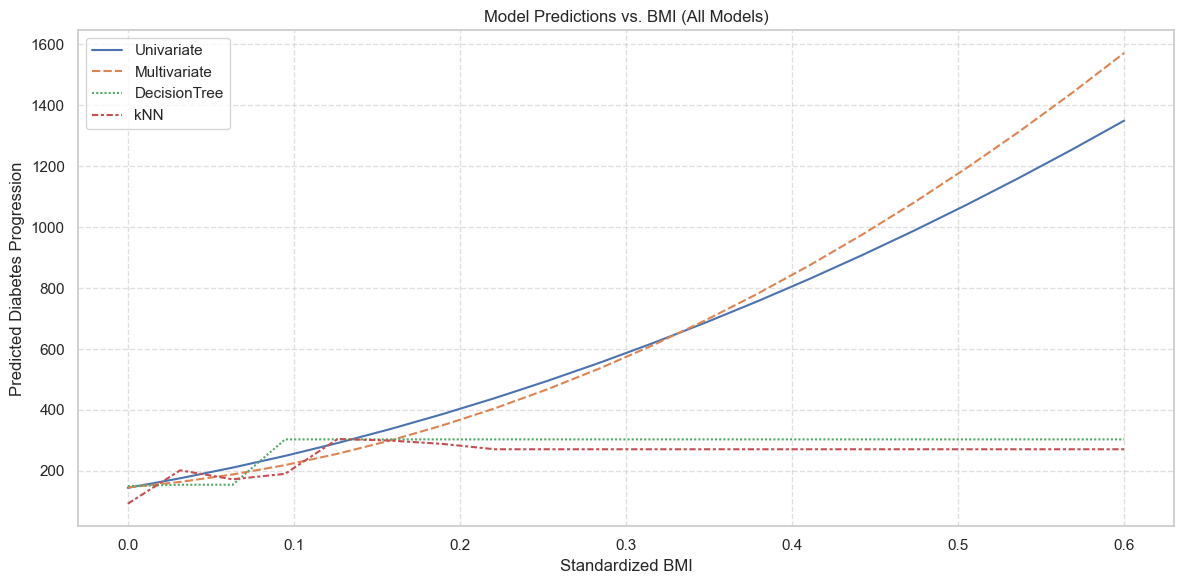

In [39]:
# Plotting the predictions from each model across BMI values
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df.set_index('BMI'))
plt.title('Model Predictions vs. BMI (All Models)')
plt.xlabel('Standardized BMI')
plt.ylabel('Predicted Diabetes Progression')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


###  Interpretation: How Each Model Predicts as BMI Increases

This graph shows how each model’s prediction changes when **BMI increases**, while keeping other features the same.

####  What We See:

- **Univariate Polynomial Regression**  
  - Smooth and curved line.  
  - Only uses BMI, so it gives a general trend but **misses other factors**.

- **Multivariate Polynomial Regression**  
  - Also smooth, but better shaped because it uses more features (like s5, bp, s4).  
  - Gives the most **realistic and balanced** predictions.

- **Decision Tree**  
  - The line looks like steps or blocks.  
  - It makes predictions in chunks, not smooth changes.  
  - Can be **less accurate for gradual changes**.

- **kNN Model**  
  - Line is a bit **jumpy**.  
  - It predicts based on nearby training points.  
  - Works okay, but not very stable at the edges.

####  Simple Conclusion:
The **Multivariate Polynomial Regression** model gives the **most smooth and reliable predictions**.  
It understands the relationship between BMI and disease better by using multiple features.


# Final Conclusion – Summary

In this notebook, we explored the Scikit-Learn diabetes dataset and built several models to predict disease progression.

### What We Did:
- We first explored the data and found that BMI is one of the most important features.
- We built different models: univariate polynomial regression, multivariate polynomial regression, decision trees, and k-nearest neighbors (kNN).
- We compared all models using R², MAE, and MAPE on train, validation, and test data.

### Best Models:
- **Univariate Model:** Degree 5 polynomial using only BMI performed best.
- **Multivariate Model:** Degree 2 polynomial using top features (`bmi`, `s5`, `bp`, `s4`) gave the best overall performance.
- **Decision Tree:** A shallow tree with `max_depth=2` gave a balanced result.
- **kNN:** Using `k=7` was better than `k=3` in terms of prediction accuracy.

### Limitations:
- Polynomial models can overfit at high degrees.
- Decision Trees may not perform well if the depth is too high.
- kNN is sensitive to feature scaling and local data patterns.

### Final Thoughts:
This lab showed how different models behave and how to choose the right one using metrics. It also showed the importance of feature selection and data understanding.


## References  
### Acknowledgment of External Help

Some of the technically challenging parts of this notebook—especially:

- Comparative evaluation of all four models using performance metrics  
- Visualizing prediction trends across models  

were developed with help from tools like **ChatGPT** and **GitHub Copilot** to assist in understanding complex logic and refining implementation.

However, all content was **carefully reviewed, rewritten, and reworked by me** through **hard effort and multiple revisions**, ensuring it reflects my own understanding, learning style, and the specific requirements of this assignment.
